In [2]:
import os
import sys
import pandas as pd
import numpy as pd
sys.path.append(os.path.join('..', 'src'))

In [2]:
from genes_annotations import *
from autoencoder import *
from utils import *

## Summary
1. [Reading the data (the expression matrix, the gene ontology), building the standardised expression matrix and the mask](#Reading-the-data-(the-expression-matrix,-the-gene-ontology),-building-the-standardised-expression-matrix-and-the-mask)

2. [Training the autoencoder](#Training-the-autoencoder)

3. [Reloading the model and getting the embeddings](#Reloading-the-model-and-getting-the-embeddings)

4. [Reading the targets and t-SNE and UMAP visualization](#Reading-the-targets-and-t\-SNE-and-UMAP-visualization)

## Reading the data (the expression matrix, the gene ontology), building the standardised expression matrix and the mask

In [3]:
filename = "../data_tisch2/Glioma_GSE102130_expression.h5"

h5 = read_h5(filename)

In [4]:
selected_genes = get_all_genes(h5)

In [6]:
goterm, genes_go, all_go, all_genes = get_all_gene_annotations(h5)

HMS:0:00:08.230363 606,840 annotations READ: ../goa_human.gaf 
../go.obo: fmt(1.2) rel(2021-02-01) 50,515 GO Terms; optional_attrs(consider replaced_by)


In [36]:
mask = build_mask(h5,genes_go,all_go,all_genes)

In [34]:
expr_mat = build_expr_mat(h5)
expr_mat = select_gene_expr_v2(h5, expr_mat, all_genes)
std_expr_mat = min_max_normalisation(std_normalisation(expr_mat))

'build_expr_mat'  306.48 ms
'select_gene_expr_v2'  314.02 ms


In [37]:
std_expr_mat.shape, mask.shape

((4058, 10232), torch.Size([10232, 1414]))

## Training the autoencoder

In [38]:
ae, train_loader, embeddings = ae_pipeline(mask, std_expr_mat, all_genes, all_go, n_epochs=100, batch_size=50, print_loss=100, output_file='model_ae_final.pth', embed_file='embeddings_ae_final.csv')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1              [-1, 1, 1514]               0
      MaskedLinear-2              [-1, 1, 1514]               0
            Linear-3               [-1, 1, 100]         151,500
              Tanh-4               [-1, 1, 100]               0
            Linear-5              [-1, 1, 1514]         152,914
              Tanh-6              [-1, 1, 1514]               0
              Tanh-7             [-1, 1, 10232]               0
      MaskedLinear-8             [-1, 1, 10232]               0
Total params: 304,414
Trainable params: 304,414
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.20
Params size (MB): 1.16
Estimated Total Size (MB): 1.40
----------------------------------------------------------------
[1,    82] loss: 0.91738
[2,    82] loss: 

## Reloading the model and getting the embeddings

In [30]:
model = torch.load('model_ae_final.pth')

In [31]:
data_tensor = torch.Tensor(std_expr_mat)
targets_tensor = torch.Tensor(targets).long()
train = torch.utils.data.TensorDataset(data_tensor, targets_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)

In [32]:
embeddings=get_embeddings(train_loader, expr_mat.shape[0], model, 500)

In [33]:
embeddings.shape

(4058, 500)

## Reading the targets and t-SNE and UMAP visualization

In [39]:
df = pd.read_csv('../data_tisch2/Glioma_GSE102130_CellMetainfo_table.tsv', delimiter='\t')

In [40]:
targets=np.array(df['Cluster'])

In [41]:
targets.shape

(4058,)

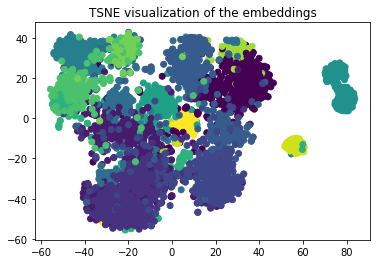

In [58]:
utils.visualize_TSNE(embeddings, targets)

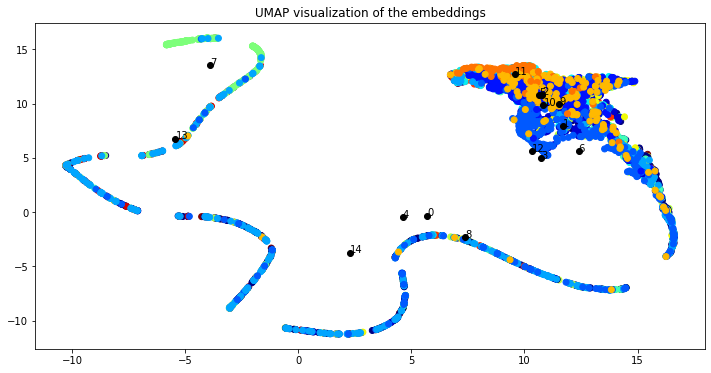

In [46]:
utils.visualize_UMAP(embeddings, targets)

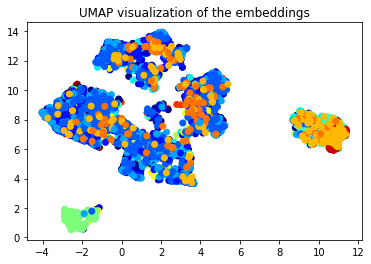

In [94]:
utils.visualize_UMAP(expr_mat[:,:20], targets)